In [44]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [45]:
# number of epochs of training
n_epochs = 4
# size of the batches
batch_size = 16
# name of the dataset
dataset_name = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
# adam: learning rate
lr = 0.00008

# adam: decay of first order momentum of gradient
b1 = 0.5

# adam: decay of first order momentum of gradient
b2 = 0.999

# number of cpu threads to use during batch generation
n_cpu = 4

# dimension de l'espace latent contient 100 nombre aleatoire pour commencer à générer une image.Ces nombres aléatoires sont la "source d'inspiration" du générateur.
#Assez grand pour que le générateur ait assez de "liberté" pour produire des images variées.
#Pas trop grand pour éviter des calculs trop lourds ou inutiles.
latent_dim = 100
# size of each image dimension
img_size = 128
# size of random mask
mask_size = 64
# number of image channels
channels = 3


# interval between image sampling
#Cela signifie qu'une image générée par le modèle sera sauvegardée toutes les 500 itérations.
#Cela te donne une série d'images qui montrent comment la qualité des résultats du modèle s'améliore au fur et à mesure de l'entraînement.
sample_interval = 500

cuda = True if torch.cuda.is_available() else False
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

# Calculate output dims of image discriminator (PatchGAN)
#Dans un PatchGAN, le discriminant ne renvoie pas une seule probabilité pour toute l'image,
# mais une grille de probabilités correspondant à chaque patch (par exemple, une grille de taille  (8*8)
#Cela permet au discriminant d'évaluer localement si chaque patch est réaliste.Cela rend l'entraînement plus efficace
patch_h, patch_w = int(mask_size / 2 ** 3), int(mask_size / 2 ** 3)
patch = (1, patch_h, patch_w)

### Define Dataset Class

In [46]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, img_size=128, mask_size=64, mode="train"):
        #Convertit la liste des transformations (transforms_) en une pipeline de transformations utilisable avec PyTorch.
        self.transform = transforms.Compose(transforms_)
        self.img_size = img_size
        self.mask_size = mask_size
        self.mode = mode
        self.files = sorted(glob.glob("%s/*.jpg" % root))
        self.files = self.files[:-4000] if mode == "train" else self.files[-4000:]

    def apply_random_mask(self, img):
        """Randomly masks image"""
        y1, x1 = np.random.randint(0, self.img_size - self.mask_size, 2)
        y2, x2 = y1 + self.mask_size, x1 + self.mask_size
        masked_part = img[:, y1:y2, x1:x2]
        masked_img = img.clone()
        #rendre les pixels blanc du mask
        masked_img[:, y1:y2, x1:x2] = 1

        return masked_img, masked_part

    def apply_center_mask(self, img):
        """Mask center part of image"""
        # Get upper-left pixel coordinate
        i = (self.img_size - self.mask_size) // 2
        masked_img = img.clone()
        masked_img[:, i : i + self.mask_size, i : i + self.mask_size] = 1

        return masked_img, i

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        img = self.transform(img)
        if self.mode == "train":
            # For training data perform random mask
            masked_img, aux = self.apply_random_mask(img)
        else:
            # For test data mask the center of the image
            masked_img, aux = self.apply_center_mask(img)

        return img, masked_img, aux

    #def __len__(self):
    #    return len(self.files)

### Get Train/Test Dataloaders

In [47]:
transforms_ = [
    transforms.Resize((img_size, img_size), Image.BICUBIC),
    #Image.BICUBIC : Utilise l'interpolation bicubique pour un redimensionnement de haute qualité
    transforms.ToTensor(),
    #Convertit l’image  en un tenseur PyTorch
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
dataloader = DataLoader(
    ImageDataset(dataset_name, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)
test_dataloader = DataLoader(
    ImageDataset(dataset_name, transforms_=transforms_, mode="val"),
    batch_size=12,
    shuffle=True,
    num_workers=1,
)

### VISUALISER LE MASK

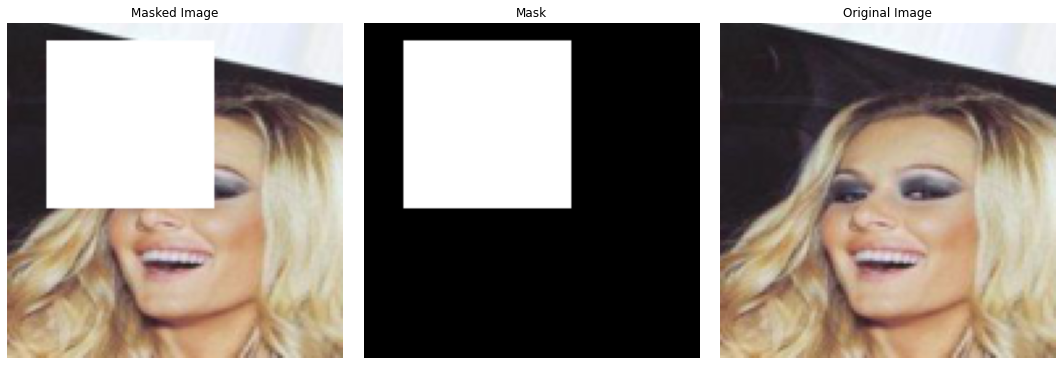

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to visualize a batch
def visualize_batch(original_imgs, masked_imgs, mask_coords_batch, mode="train"):
    # Select the first image in the batch
    original_image = original_imgs[0]  # Original unmasked image
    masked_image = masked_imgs[0]      # Masked image
    mask_coords = mask_coords_batch[0] # Mask coordinates for the first image

    # Ensure mask_coords has exactly 4 elements
    if mask_coords.numel() != 4:
        raise ValueError(f"Expected mask_coords to have 4 elements, but got {mask_coords.numel()}")

    # Extract mask coordinates
    y1, x1, y2, x2 = [int(coord.item()) for coord in mask_coords]

    img_size = original_image.shape[1]  # Image height/width
    mask_size = 64  # Set the mask size (same as in ImageDataset)

    # Create binary mask
    mask_np = np.zeros((img_size, img_size))
    mask_np[y1:y2, x1:x2] = 1  # Create binary mask

    # Convert tensors to NumPy arrays and transpose for visualization
    original_image_np = original_image.permute(1, 2, 0).cpu().numpy()  # [C, H, W] -> [H, W, C]
    masked_image_np = masked_image.permute(1, 2, 0).cpu().numpy()      # [C, H, W] -> [H, W, C]

    # Denormalize images (from [-1, 1] to [0, 1])
    original_image_np = (original_image_np * 0.5) + 0.5
    masked_image_np = (masked_image_np * 0.5) + 0.5

    # Clip values to [0, 1] to avoid any potential out-of-bound values due to numerical errors
    original_image_np = np.clip(original_image_np, 0, 1)
    masked_image_np = np.clip(masked_image_np, 0, 1)

    # Plot the masked image, mask, and original image
    plt.figure(figsize=(15, 5))

    # Masked Image
    plt.subplot(1, 3, 1)
    plt.imshow(masked_image_np)
    plt.title("Masked Image")
    plt.axis("off")

    # Mask (as binary)
    plt.subplot(1, 3, 2)
    plt.imshow(mask_np, cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    # Original Image
    plt.subplot(1, 3, 3)
    plt.imshow(original_image_np)
    plt.title("Original Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage with the training dataloader
try:
    # Get one batch from the dataloader
    original_imgs, masked_imgs, mask_coords_batch = next(iter(dataloader))
    
    # Visualize the first image in the batch
    visualize_batch(original_imgs, masked_imgs, mask_coords_batch, mode="train")
except Exception as e:
    print(f"An error occurred during visualization: {e}")


### Define Model Classes

In [14]:
class Generator(nn.Module):
    def __init__(self, channels=3):
        super(Generator, self).__init__()
         
        def downsample(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers
        
        def upsample(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.ReLU())
            return layers

        self.model = nn.Sequential(
            *downsample(channels, 64, normalize=False),
            *downsample(64, 64),
            *downsample(64, 128),
            *downsample(128, 256),
            *downsample(256, 512),
            nn.Conv2d(512, 4000, 1),
            #Elle applique des kernels de taille 1x1 pour chaque canal, ce
            #qui permet de projeter les 512 canaux d'entrée vers 4000 canaux de sortie tout en gardant la même résolution spatiale.
            #transformation linéaire indépendante pour chaque pixel.
            # permet au réseau d'encoder plus de caractéristiques complexes avant l'étape d'upsampling.
            *upsample(4000, 512),
            *upsample(512, 256),
            *upsample(256, 128),
            *upsample(128, 64),
            nn.Conv2d(64, channels, 3, 1, 1),
            nn.Tanh()#normaliser les pixels entre [-1, 1].
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize):
            """Returns layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = channels
        for out_filters, stride, normalize in [(64, 2, False), (128, 2, True), (256, 2, True), (512, 1, True)]:
            layers.extend(discriminator_block(in_filters, out_filters, stride, normalize))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

### Train Context-Encoder GAN

In [ ]:
#Cette fonction initialise les poids des couches d'un réseau selon une distribution normale pour assurer un bon départ à l'entraînement.
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

#La fonction identifie les couches par leur nom de classe (m.__class__.__name__).
#Pour les couches convolutionnelles ("Conv"), les poids sont initialisés suivant une distribution normale avec une moyenne de 0.0 et un écart-type de 0.02.
#Pour les couches BatchNorm2d, les poids sont initialisés avec une moyenne de 1.0 et un écart-type de 0.02, et les biais sont fixés à 0.0

def save_sample(batches_done):
    samples, masked_samples, i = next(iter(test_dataloader))
    samples = Variable(samples.type(Tensor))
    masked_samples = Variable(masked_samples.type(Tensor))
    i = i[0].item()  # Upper-left coordinate of mask
    # Generate inpainted image
    gen_mask = generator(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples[:, :, i : i + mask_size, i : i + mask_size] = gen_mask
    # Save sample
    sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)
    save_image(sample, "images/%d.png" % batches_done, nrow=6, normalize=True)

    
# Loss function
adversarial_loss = torch.nn.MSELoss()
#mesure la perte adversariale
# Elle mesure la différence entre la prédiction du discriminateur et les valeurs réelles (1.0 pour vrai, 0.0 pour faux).
pixelwise_loss = torch.nn.L1Loss()
#pixelwise_loss : mesure la différence L1 (manhattan) entre l'image originale et celle remplie.
# mesurer la différence au niveau des pixels entre l'image générée et l'image originale. La norme L1 favorise des reconstructions réalistes avec moins de flou.


# Initialize generator and discriminator
generator = Generator(channels=channels)
discriminator = Discriminator(channels=channels)


if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

### l'entrainement

In [18]:
gen_adv_losses, gen_pixel_losses, disc_losses, counter = [], [], [], []
#Ces listes servent à enregistrer les pertes du générateur et du discriminateur pour chaque itération d'entraînement afin de suivre les performances du modèle.
for epoch in range(n_epochs):
    
    ### Training ###
    gen_adv_loss, gen_pixel_loss, disc_loss = 0, 0, 0
    tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)))
    for i, (imgs, masked_imgs, masked_parts) in enumerate(tqdm_bar):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], *patch).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0), requires_grad=False)

        # Configure input
        #Convertit les données en tenseurs PyTorch compatibles
        imgs = Variable(imgs.type(Tensor))
        masked_imgs = Variable(masked_imgs.type(Tensor))
        masked_parts = Variable(masked_parts.type(Tensor))

        ## Train Generator ##
        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_parts = generator(masked_imgs)

        # Adversarial and pixelwise loss
        #Calcul des pertes adversariale et pixelwise
        g_adv = adversarial_loss(discriminator(gen_parts), valid)
        g_pixel = pixelwise_loss(gen_parts, masked_parts)
        # Total loss
        g_loss = 0.001 * g_adv + 0.999 * g_pixel

        g_loss.backward()
        optimizer_G.step()

        ## Train Discriminator ##
        optimizer_D.zero_grad()
        #réinitialise les gradients du discriminateur.

        
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(masked_parts), valid)
        fake_loss = adversarial_loss(discriminator(gen_parts.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()
        
        '''''
        gen_adv_loss, gen_pixel_loss, disc_loss
        gen_adv_losses, gen_pixel_losses, disc_losses, counter
        
        gen_adv_loss += g_adv.item()
        gen_pixel_loss += g_pixel.item()
        gen_adv_losses.append(g_adv.item())
        gen_pixel_losses.append(g_pixel.item())
        disc_loss += d_loss.item()
        disc_losses.append(d_loss.item())
        counter.append(i*batch_size + imgs.size(0) + epoch*len(dataloader.dataset))
        tqdm_bar.set_postfix(gen_adv_loss=gen_adv_loss/(i+1), gen_pixel_loss=gen_pixel_loss/(i+1), disc_loss=disc_loss/(i+1))
        
        # Generate sample at sample interval
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_sample(batches_done)
            '''''
    torch.save(generator.state_dict(), "saved_models/generator.pth")
    torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

In [36]:
import torch
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

### Generer un mask

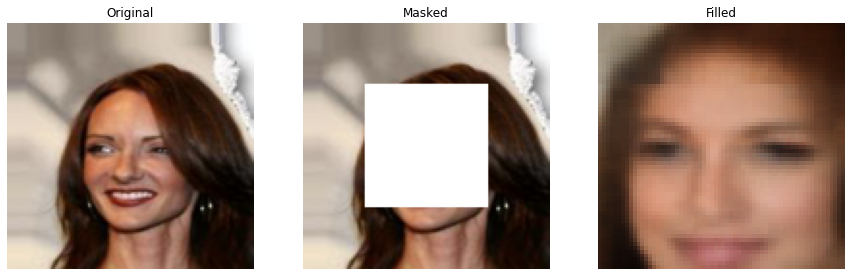

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
generator = Generator()  # Same architecture used during training
generator.load_state_dict(torch.load(
    "/kaggle/input/context-encoder-gan-for-image-inpainting-pytorch/saved_models/generator.pth", 
    map_location=device  # Automatically map to the correct device
))
generator.to(device)  # Move the model to the GPU if available
generator.eval()

# Get the first batch
img, masked_img, aux = next(iter(test_dataloader))

# Select only the first image from the batch
img = img[0].unsqueeze(0).to(device)  # Move to the GPU if available
masked_img = masked_img[0].unsqueeze(0).to(device)

with torch.no_grad():
    filled_img = generator(masked_img)

# Denormalize from [-1,1] to [0,1]
img = 0.5 * (img + 1.0)
masked_img = 0.5 * (masked_img + 1.0)
filled_img = 0.5 * (filled_img + 1.0)

# Convert to PIL images for visualization
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

original_pil = to_pil_image(img[0].cpu())  # Move back to CPU for visualization
masked_pil = to_pil_image(masked_img[0].cpu())
filled_pil = to_pil_image(filled_img[0].cpu())

# Display the results
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(original_pil)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Masked")
plt.imshow(masked_pil)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Filled")
plt.imshow(filled_pil)
plt.axis("off")

plt.show()


### Combiner

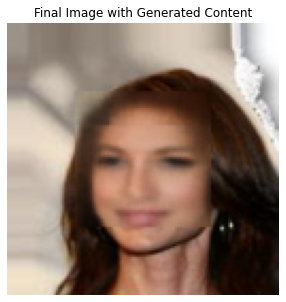

In [38]:
from PIL import Image


# Replace the masked region with the generated content
mask_size = 64  # Ensure this matches the mask size during training
start = (masked_np.shape[1] - mask_size) // 2  # Mask start position
end = start + mask_size  # Mask end position

# Resize the filled patch to match the mask size (if necessary)
from skimage.transform import resize
filled_patch = filled_np[:, :mask_size, :mask_size]  # Extract generated patch
filled_patch_resized = resize(filled_patch, (3, mask_size, mask_size), mode='reflect')

# Insert the resized patch into the blank region
final_image_np = masked_np.copy()  # Start with the masked image
final_image_np[:, start:end, start:end] = filled_patch_resized  # Fill the blank

# Convert the final image to a PIL image
final_image_pil = to_pil_image(torch.tensor(final_image_np))

# Display the final combined image
plt.figure(figsize=(10, 5))
plt.imshow(final_image_pil)
plt.axis("off")
plt.title("Final Image with Generated Content")
plt.show()

# Save the final image
final_image_pil.save("final_image.jpg")
